In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.parser import parse
from datetime import datetime, timedelta
import shapely

%matplotlib inline

In [2]:
sfcrime = pd.read_csv('data/SFPD_Incidents_-_from_1_January_2003.csv')
sfcrime.head(1)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000


In [3]:
#sfcrime['Date'] = pd.to_datetime(sfcrime['Date'])
#sfcrime['Time'] = sfcrime['Time'].apply(lambda x: datetime.strptime(x,'%H:%M'))

In [4]:
del sfcrime['Resolution']
del sfcrime['X']
del sfcrime['Y']
del sfcrime['PdId']

In [5]:
sfcrime_copy = sfcrime.copy()
sfcrime_copy.head(1)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Address,Location
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,18TH ST / VALENCIA ST,"(37.7617007179518, -122.42158168137)"


In [6]:
print sfcrime_copy.shape
print sfcrime_copy['Date'].max()
print sfcrime_copy['Date'].min()

(2046067, 9)
12/31/2016
01/01/2003


In [7]:
sfcrime_copy['Year'] = pd.DatetimeIndex(sfcrime_copy['Date']).year
sfcrime_copy['Month'] = pd.DatetimeIndex(sfcrime_copy['Date']).month
sfcrime_copy['Hour'] = pd.DatetimeIndex(sfcrime_copy['Time']).hour
sfcrime_copy['Day'] = pd.DatetimeIndex(sfcrime_copy['Date']).dayofweek

In [8]:
sfcrime_copy[sfcrime_copy['Category'] == 'OTHER OFFENSES']['Descript'].unique()

array(['DRIVERS LICENSE, SUSPENDED OR REVOKED', 'RESISTING ARREST',
       'TRAFFIC VIOLATION', 'TAMPERING WITH A VEHICLE',
       'PROBATION VIOLATION', 'POSSESSION OF BURGLARY TOOLS',
       'HARASSING PHONE CALLS', 'TRAFFIC VIOLATION ARREST',
       'MISCELLANEOUS INVESTIGATION',
       'CONTRIBUTING TO THE DELINQUENCY OF MINOR',
       'SCHOOL PROPERTY, DISTURBANCE ON', 'FALSE REPORT OF BOMB',
       'LOST/STOLEN LICENSE PLATE', 'MISCELLANEOUS STATE MISDEMEANOR',
       'STAY AWAY ORDER VIOLATION, DV RELATED', 'VIOLATION OF PARK CODE',
       'INCIDENT ON SCHOOL GROUNDS',
       'FALSE PERSONATION AND CHEAT CRIMES (GENERAL)',
       'FRAUDULENT GAME OR TRICK, OBTAINING MONEY OR PROPERTY',
       'FALSE PERSONATION TO RECEIVE MONEY OR PROPERTY',
       'WEARING MASK OR DISGUISE FOR UNLAWFUL PURPOSE',
       'VIOLATION OF STAY AWAY ORDER',
       'FALSE EVIDENCE OF VEHICLE REGISTRATION',
       'VIOLATION OF MUNICIPAL CODE', 'VIOLATION OF RESTRAINING ORDER',
       'COMPUTER SYSTEM, 

In [9]:
sfcrime_copy.head(1)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Address,Location,Year,Month,Hour,Day
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,18TH ST / VALENCIA ST,"(37.7617007179518, -122.42158168137)",2015,1,14,0


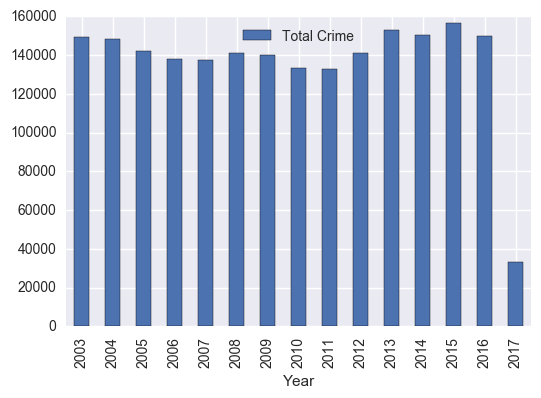

In [10]:
by_year = sfcrime_copy.groupby(['Year'])['Date'].count().reset_index()
by_year.columns = ['Year', 'Total Crime']
by_year.plot(kind ='bar', x='Year', y='Total Crime');

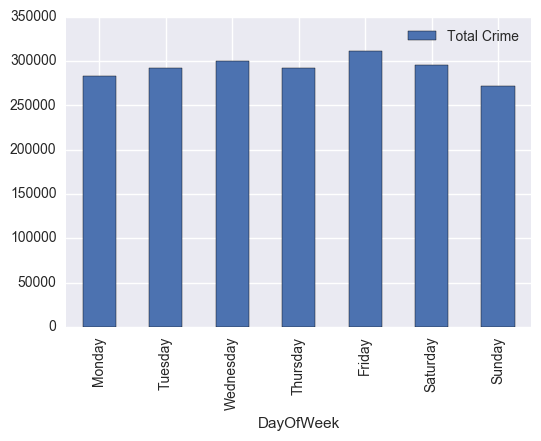

In [11]:
by_DayOfWeek = sfcrime_copy.groupby(['Day', 'DayOfWeek'])['Date'].count().reset_index()
by_DayOfWeek.columns = ['Day', 'DayOfWeek', 'Total Crime']
by_DayOfWeek.plot(kind ='bar', x='DayOfWeek', y='Total Crime');

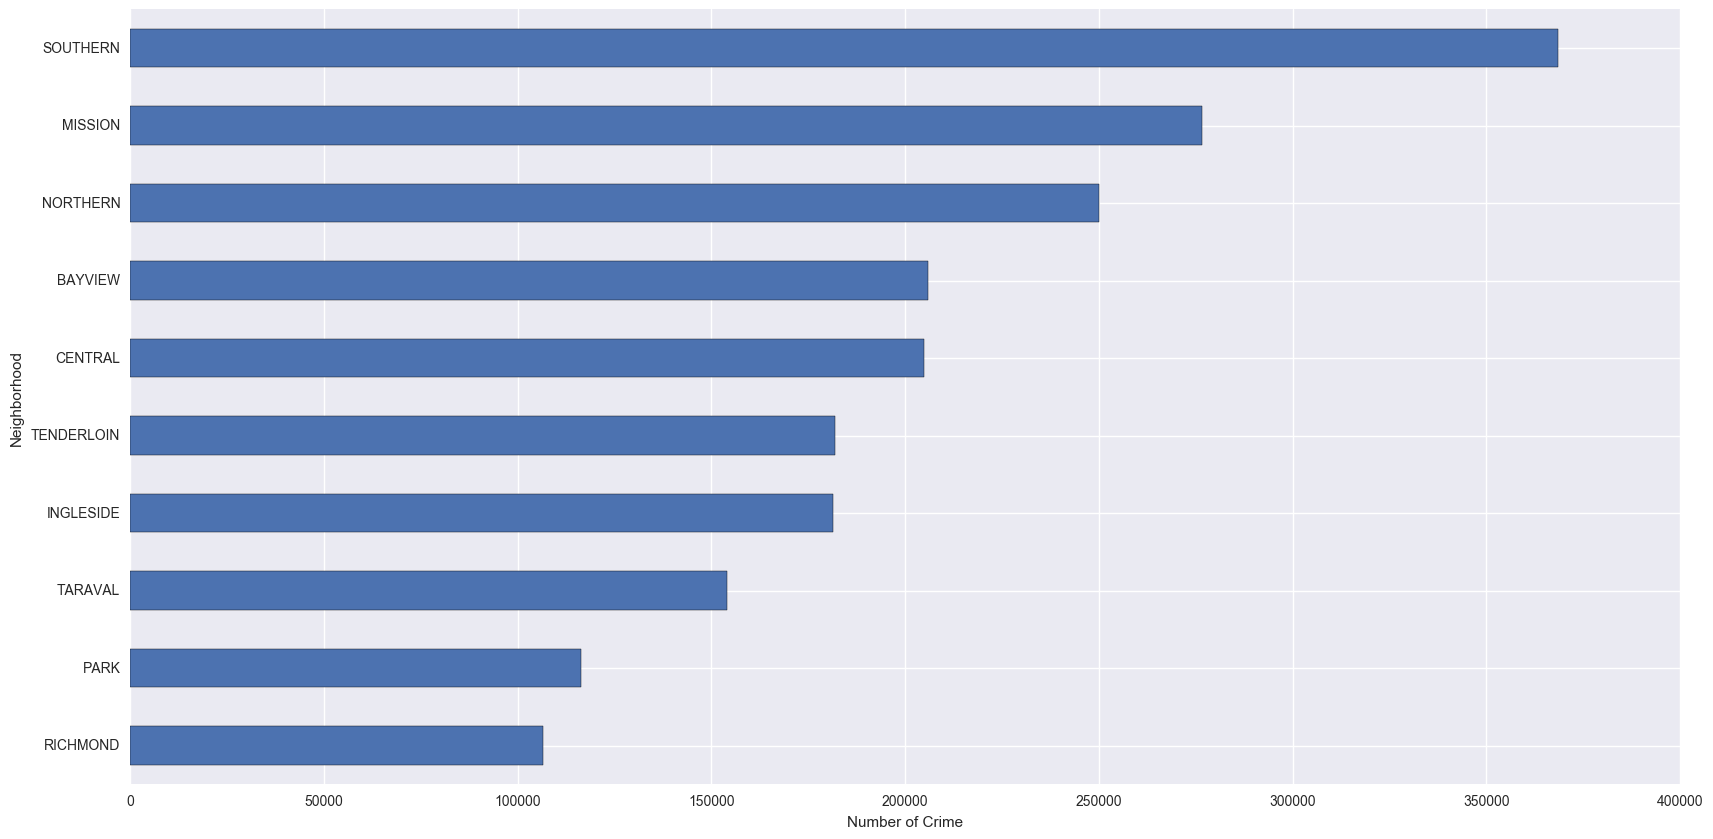

In [12]:
plt.figure(figsize=(20,10))
sfcrime_copy['PdDistrict'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Crime')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
plt.show()

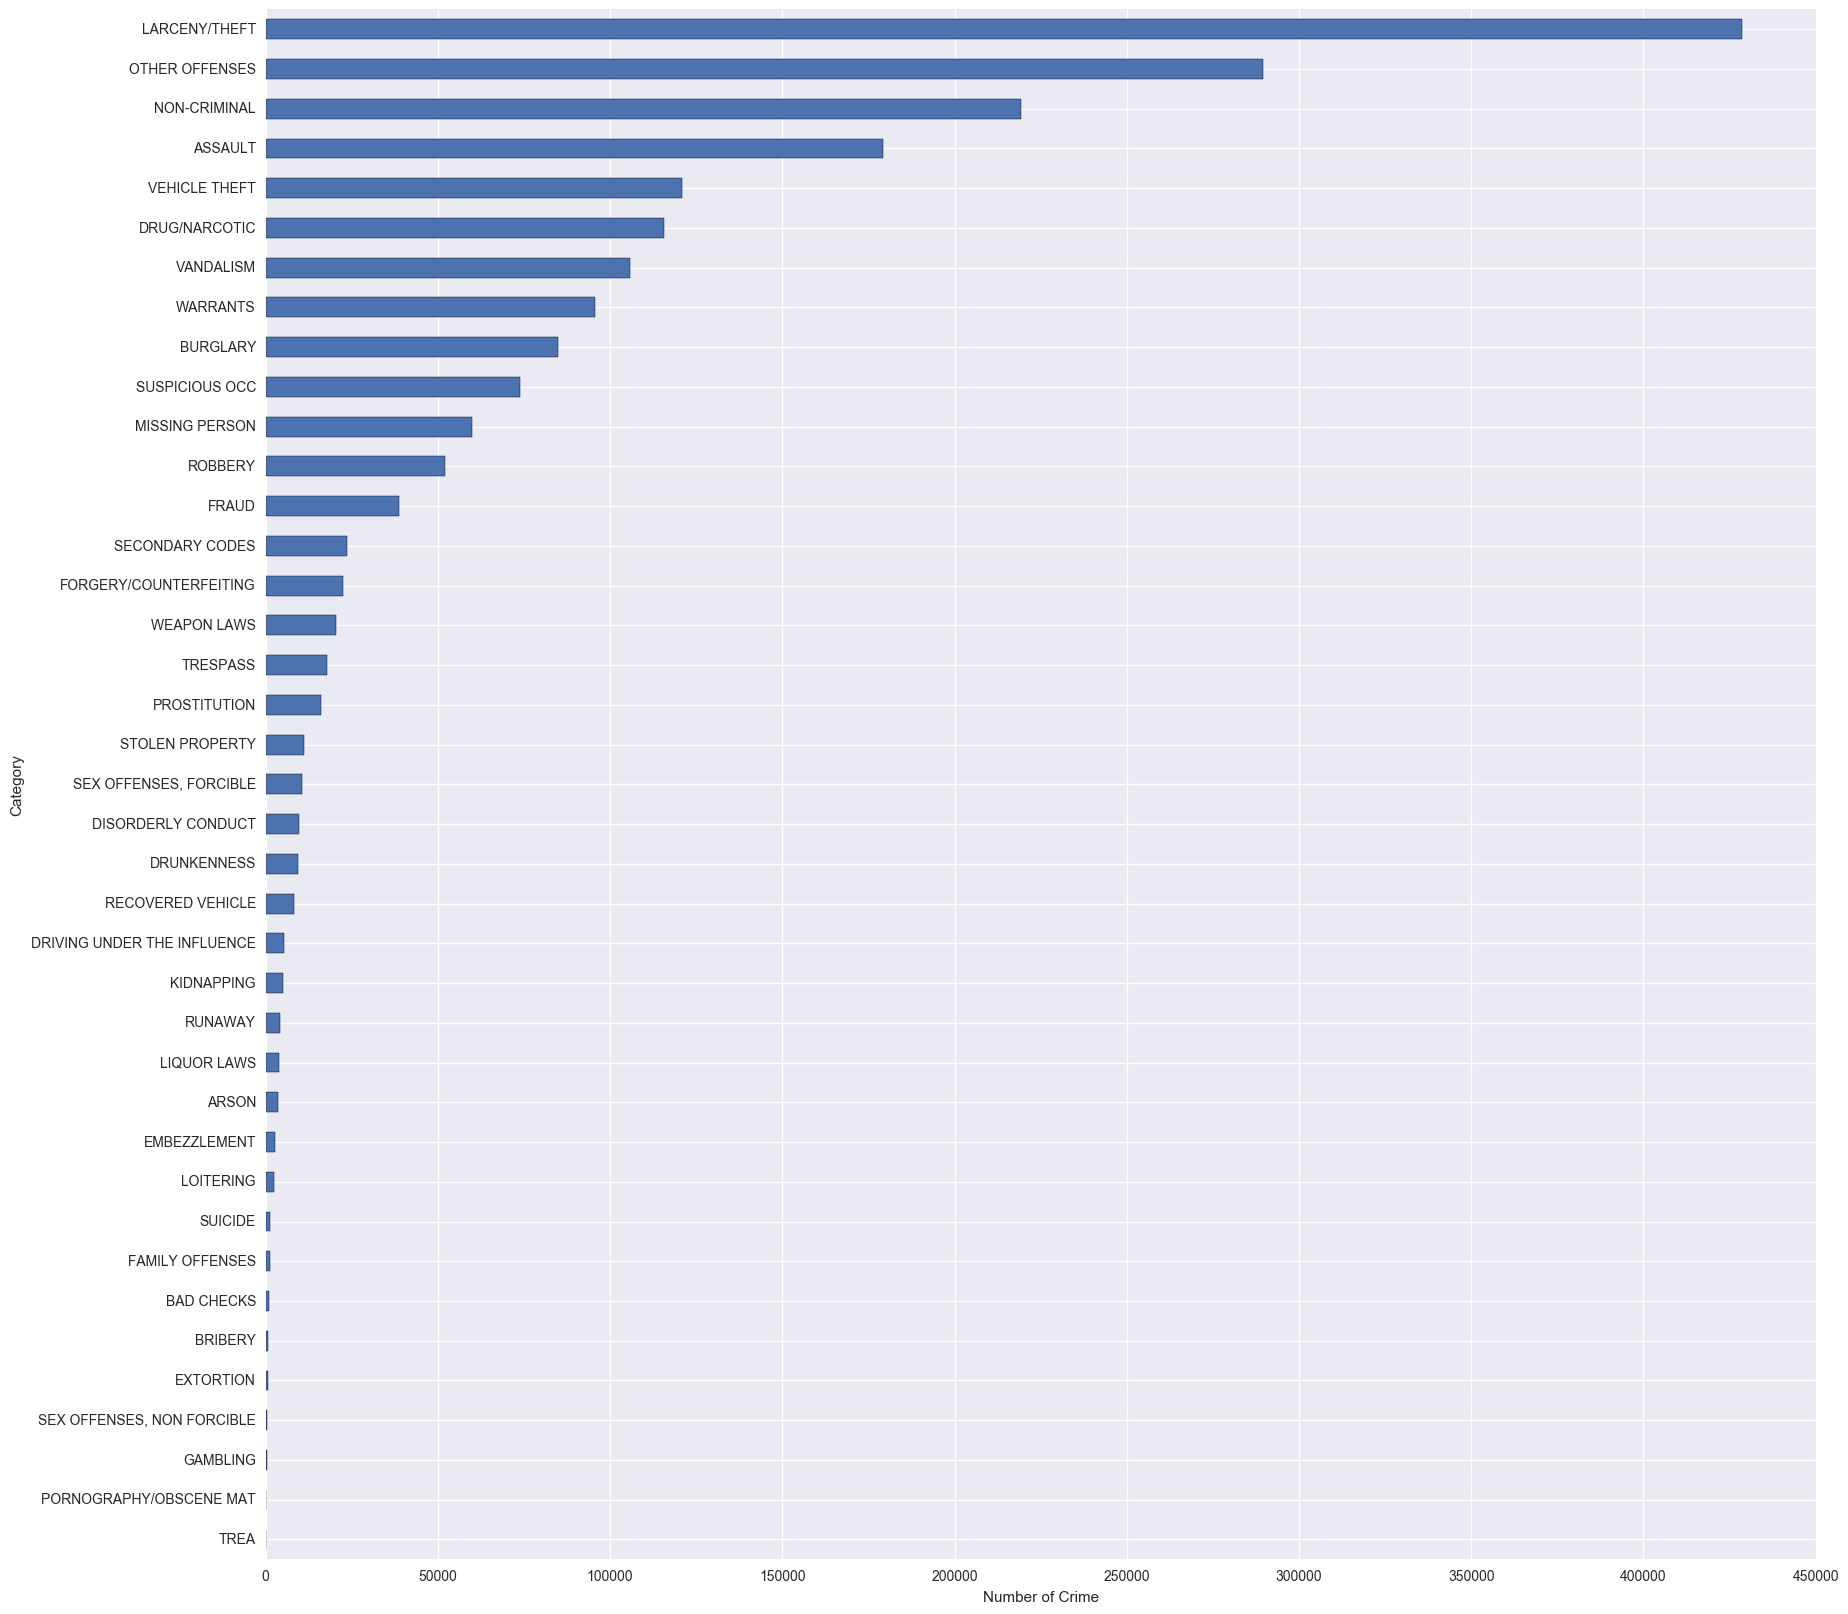

In [13]:
plt.figure(figsize=(20,20))
sfcrime_copy['Category'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Crime')
plt.ylabel('Category')
plt.gca().invert_yaxis()
plt.show()

In [14]:
# Create Types of crime
crimeDict = {
    'ROBBERY': 'VIOLENT',
    'ASSAULT':'VIOLENT', 
    'ARSON':'VIOLENT', 
    'SEX OFFENSES, FORCIBLE':'VIOLENT',
    'KIDNAPPING':'VIOLENT',
    
    'BURGLARY': 'NON-VIOLENT',
    'PORNOGRAPHY/OBSCENE MAT': 'NON-VIOLENT',
    'LARCENY/THEFT': 'NON-VIOLENT',
    'PROSTITUTION': 'NON-VIOLENT',
    'DISORDERLY CONDUCT': 'NON-VIOLENT',
    'SEX OFFENSES, NON FORCIBLE': 'NON-VIOLENT',
    'DRUG/NARCOTIC': 'NON-VIOLENT',
    'DRUNKENNESS': 'NON-VIOLENT',
    'LIQUOR LAWS': 'NON-VIOLENT',
    'DRIVING UNDER THE INFLUENCE': 'NON-VIOLENT',
    
    'FRAUD': 'WHITE-COLLAR',
    'FORGERY/COUNTERFEITING': 'WHITE-COLLAR',
    'EXTORTION': 'WHITE-COLLAR',
    'EMBEZZLEMENT': 'WHITE-COLLAR',
    'BRIBERY': 'WHITE-COLLAR',
    'BAD CHECKS': 'WHITE-COLLAR',
    'GAMBLING': 'WHITE-COLLAR',
    
    'TRESPASS': 'PROPERTY',
    'STOLEN PROPERTY': 'PROPERTY',
    'LOITERING': 'PROPERTY',
    'VEHICLE THEFT': 'PROPERTY',
    'VANDALISM': 'PROPERTY',
    'TREA': 'PROPERTY',
    
    'SECONDARY CODES': 'OTHER',
    'OTHER OFFENSES': 'OTHER',
    'SUICIDE': 'OTHER',
    'WEAPON LAWS': 'OTHER',
    'MISSING PERSON': 'OTHER',
    'SUSPICIOUS OCC': 'OTHER',
    'FAMILY OFFENSES': 'OTHER',
    'RECOVERED VEHICLE': 'OTHER',
    'NON-CRIMINAL': 'OTHER',
    'WARRANTS': 'OTHER', 
    'RUNAWAY': 'OTHER'}

In [15]:
def add_type(cat):
    for x, y in crimeDict.items():
        cat = str(cat)
        if x in cat:
            return y
    return 'OTHER'

In [16]:
sfcrime_copy['Type'] = sfcrime_copy['Category'].apply(add_type)
sfcrime_copy.head(1)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Address,Location,Year,Month,Hour,Day,Type
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,18TH ST / VALENCIA ST,"(37.7617007179518, -122.42158168137)",2015,1,14,0,OTHER


In [17]:
#pd.DataFrame(sfcrime_copy).to_csv('data/sfcrime_copy.csv')

In [18]:
sfcrime_copy_no_wc = sfcrime_copy.drop(sfcrime_copy.index[sfcrime_copy['Type'] == 'WHITE-COLLAR'])
sfcrime_copy_no_wc.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Address,Location,Year,Month,Hour,Day,Type
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,18TH ST / VALENCIA ST,"(37.7617007179518, -122.42158168137)",2015,1,14,0,OTHER
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,300 Block of LEAVENWORTH ST,"(37.7841907151119, -122.414406029855)",2015,2,15,6,VIOLENT
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,300 Block of LEAVENWORTH ST,"(37.7841907151119, -122.414406029855)",2015,2,15,6,VIOLENT
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,300 Block of LEAVENWORTH ST,"(37.7841907151119, -122.414406029855)",2015,2,15,6,OTHER
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,LOMBARD ST / LAGUNA ST,"(37.8004687042875, -122.431118543788)",2015,1,19,1,PROPERTY


In [19]:
#pd.DataFrame(sfcrime_copy_no_wc).to_csv('data/sfcrime_filter_no_wc.csv')

## Update San Francisco Neighborhoods

In [20]:
#Shapefile of Neighborhoods in San Francisco
sfneighborhoods = gpd.read_file("./data/AnalysisNeighborhoods/geo_export_e6ad2522-9d21-4211-be48-e66ab369225f.shp")
sfneighborhoods.head(1)

,nhood,geometry
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...


In [21]:
def to_latitude(loc):
    loc = loc.replace("(","")
    loc = loc.split(",")
    return float(loc[0])

def to_longitude(loc):
    loc = loc.replace(")","")
    loc = loc.split(",")
    return float(loc[1])

sfcrime_copy_no_wc['latitude'] = sfcrime_copy_no_wc['Location'].apply(to_latitude)
sfcrime_copy_no_wc['longitude'] = sfcrime_copy_no_wc['Location'].apply(to_longitude)

In [22]:
#convert sfcrime dataframe to geodataframe
sfcrime_geo = gpd.GeoDataFrame(sfcrime_copy_no_wc, geometry=sfcrime_copy.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))
sfcrime_geo.head(1)

KeyError: ('longitude', u'occurred at index 0')

In [ ]:
def assign_nhood(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in sfneighborhoods['geometry']]
    if True in bools:
        return sfneighborhoods.iloc[bools.index(True)]['nhood']
    else:
        return np.nan

In [ ]:
sfcrime_geo['Neighborhoods'] = sfcrime_geo.apply(assign_nhood, axis='columns')
sfcrime_geo.head(1)

In [ ]:
#pd.DataFrame(sfcrime_geo).to_csv('data/sfcrime_filtergeo.csv')

In [ ]:
plt.figure(figsize=(20,10))
sfcrime_geo['Neighborhoods'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Crime')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
#plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sfcrime_geo['Neighborhoods'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Crime')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
#plt.tight_layout()
plt.show()

In [ ]:
sfcrime_filter = pd.read_csv('data/sfcrime_filter.csv')
sfcrime_filter.head(1)

In [ ]:
sfcrimegeotime = pd.read_csv('mayusedata/sfcrime_no_wc.csv')
sfcrimegeotime.head()

In [ ]:
print sfcrimegeotime.shape
print sfcrimegeotime['Date'].max()
print sfcrimegeotime['Date'].min()

In [ ]:
del sfcrimegeotime['Unnamed: 0']
del sfcrimegeotime['Resolution']
del sfcrimegeotime['PdId']

In [ ]:
# sfcrime_filter = pd.read_csv('data/sfcrime_filter.csv')
# del sfcrime_filter['Unnamed: 0']
# sfcrime_filter.head(1)

In [ ]:
sfcrime_copy_no_wc = sfcrime_copy.drop(sfcrime_copy.index[sfcrime_copy['Type'] == 'WHITE-COLLAR'])

In [ ]:
sfcrime_copy_no_wc.head(1)

In [ ]:
#pd.DataFrame(sfcrime_copy_no_wc).to_csv('data/sfcrime_filter_no_wc.csv')

In [ ]:
sfcrime_copy_no_wc = pd.read_csv('data/sfcrime_filter_no_wc.csv')

In [ ]:
del sfcrime_copy_no_wc['Unnamed: 0']
sfcrime_copy_no_wc.head(1)

In [ ]:
plt.figure(figsize=(5,5))
sfcrime_copy_no_wc['Type'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Crime')
plt.ylabel('Type')
plt.gca().invert_yaxis()
plt.show()